# LSTMs

In [12]:
import matplotlib.pyplot as plt

def panel(ax_sx, hist, panel_title, trn_val, dev_val):
    ax_sx.set_title(panel_title)
    ax_sx.plot(hist.history[trn_val], color='#1f77b4')
    ax_sx.set_ylabel('train', color='#1f77b4')
    ax_sx.tick_params('y', colors='#1f77b4')
    ax_dx = ax_sx.twinx()
    ax_dx.plot(hist.history[dev_val], color='#ff7f0e')
    ax_dx.set_ylabel('validation', color='#ff7f0e')
    ax_dx.tick_params('y', colors='#ff7f0e')    

def show_training(history):
    fig, (ax11, ax12) = plt.subplots(1, 2, figsize=(10, 4), dpi=300)
    fig.suptitle('Training model', y=1.05)
    panel(ax11, history, 'accuracy', 'acc', 'val_acc')
    panel(ax12, history, 'loss', 'loss', 'val_loss')
    fig.tight_layout()
    plt.show()  


# Data

In [13]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import keras

# read in the training data
train_data = pd.read_csv('../data/sa_train.csv')
print(len(train_data), train_data['output'].unique())

train_texts = train_data['input']
# create the tokenizer
t = Tokenizer()
# fit the tokenizer on the documents
t.fit_on_texts(train_texts)

X_train = t.texts_to_sequences(train_texts)
print(len(X_train))

# transform labels into numbers
labels2numbers = LabelEncoder()

y_train_org = labels2numbers.fit_transform(train_data['output'])
print(y_train_org[:10], len(y_train_org))

# read in test data
test_data = pd.read_csv('../data/sa_test.csv')
print(len(test_data), test_data['output'].unique())

test_texts = test_data['input']

X_test = t.texts_to_sequences(test_texts)
print(len(X_test))

y_test_org = labels2numbers.transform(test_data['output'])
print(y_test_org[:10], len(y_test_org))

# get number of classes for transformation
num_classes = max(y_train_org) + 1
# get vocabulary size
vocab_size = len(t.word_index) + 1 # vocabulary size (plus reserved index 0)

print('Convert class vector to binary 1-hot encoding matrix (for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(y_train_org, num_classes)
y_test = keras.utils.to_categorical(y_test_org, num_classes)
print(vocab_size)

1800 ['neg' 'pos']
1800
[0 0 0 1 1 0 1 1 0 0] 1800
200 ['pos' 'neg']
200
[1 0 0 0 1 0 0 1 0 0] 200
Convert class vector to binary 1-hot encoding matrix (for use with categorical_crossentropy)
37948


# LSTM

In [14]:
# in Keras (from keras examples):
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, CuDNNLSTM, Embedding, Flatten, initializers
from keras.layers.core import Lambda, Dropout, Dense, Activation
from keras.layers.convolutional import Conv1D
from keras import backend as K

hidden_dims = 96
lstm_dims = 48

model = Sequential()
model.add(Embedding(output_dim=64, 
                    input_dim=vocab_size,
                    input_length=None))
model.add(LSTM(lstm_dims))
# model.add(CuDNNLSTM(lstm_dims))
model.add(Dense(hidden_dims))
model.add(Dropout(rate=0.2))
model.add(Activation('relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          2428672   
_________________________________________________________________
lstm_4 (LSTM)                (None, 48)                21696     
_________________________________________________________________
dense_7 (Dense)              (None, 96)                4704      
_________________________________________________________________
dropout_4 (Dropout)          (None, 96)                0         
_________________________________________________________________
activation_7 (Activation)    (None, 96)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 194       
_________________________________________________________________
activation_8 (Activation)    (None, 2)                 0         
Total para

In [15]:
k = sorted([len(xx) for xx in X_train])
f = k[int(len(k)/100*90)]

from keras.preprocessing.sequence import pad_sequences

maxlen = f

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [16]:
batch_size = 32
epochs = 5

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

loss, accuracy = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Train on 1440 samples, validate on 360 samples
Epoch 1/5
1440/1440 [==============================] - 117s 81ms/step - loss: 0.6937 - acc: 0.5083 - val_loss: 0.6923 - val_acc: 0.5000
Epoch 2/5
1440/1440 [==============================] - 126s 88ms/step - loss: 0.6918 - acc: 0.5014 - val_loss: 0.6915 - val_acc: 0.5000
Epoch 3/5
1440/1440 [==============================] - 113s 79ms/step - loss: 0.6934 - acc: 0.5090 - val_loss: 0.6916 - val_acc: 0.5083
Epoch 4/5
1440/1440 [==============================] - 118s 82ms/step - loss: 0.6671 - acc: 0.5569 - val_loss: 0.6920 - val_acc: 0.5056
Epoch 5/5
200/200 [==============================] - 3s 16ms/step
Test loss: 0.6846750020980835
Test accuracy: 0.59


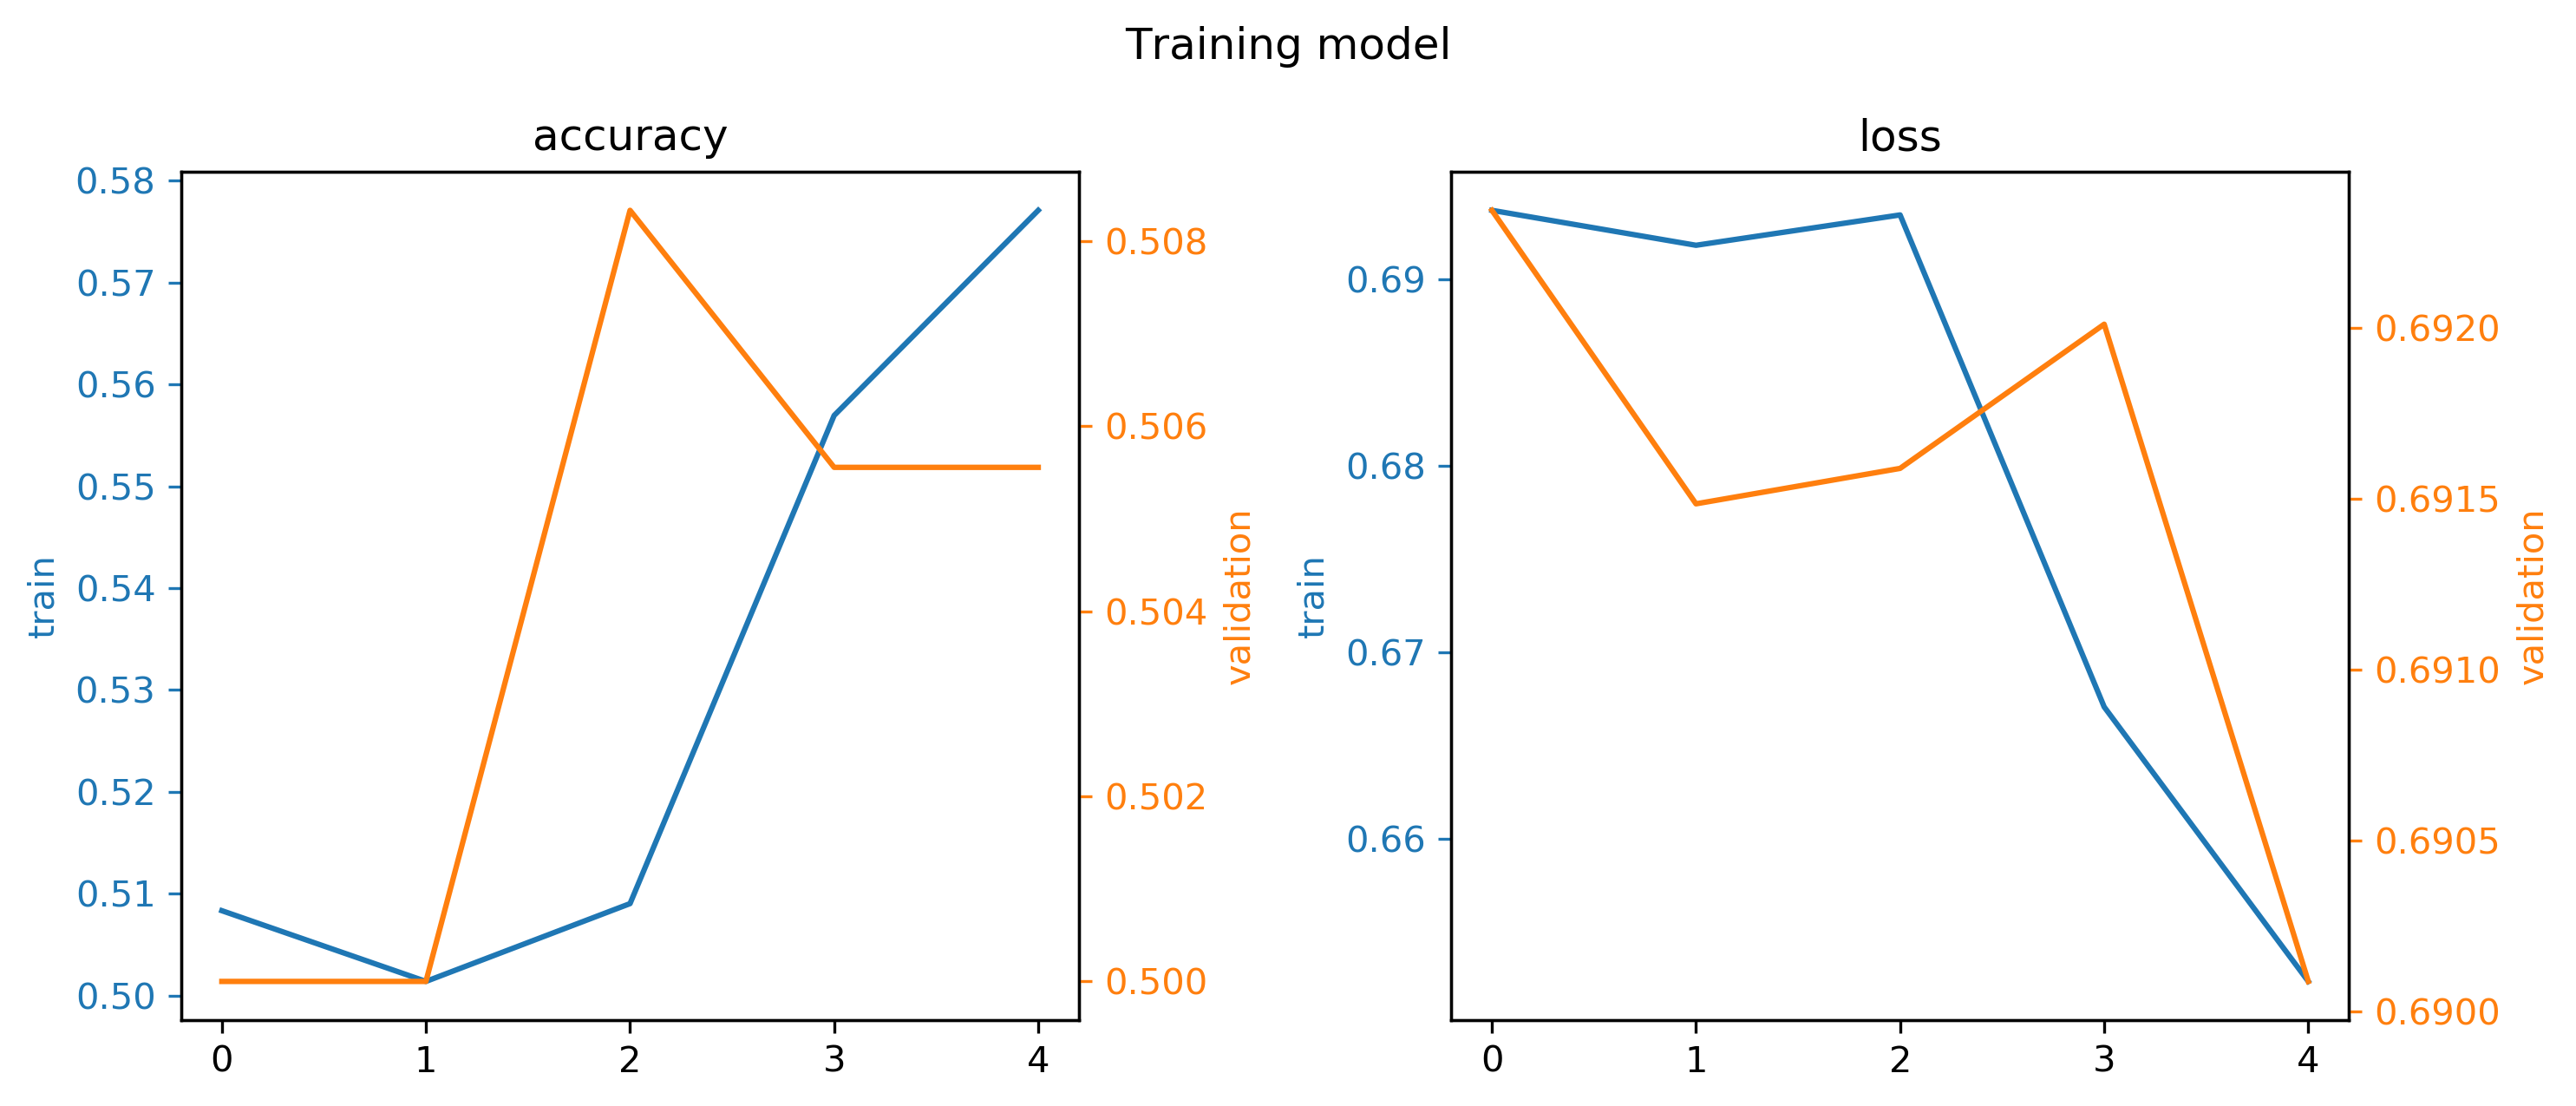

In [17]:
show_training(history)

# Attention

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
 
    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
 
        return context_vector, attention_weights